In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
data = pd.read_csv('伦敦布伦特原油期货历史数据(清洗).csv',encoding='gb2312')
data.head()

,日期,收盘,开盘,高,低,交易量,涨跌幅
0,2021/12/20,71.52,72.82,72.87,69.28,333.76K,-0.0272
1,2021/12/21,73.98,71.88,74.27,71.24,214.07K,0.0344
2,2021/12/22,75.29,74.05,75.67,73.62,166.71K,0.0177
3,2021/12/23,76.85,75.47,77.00,74.78,161.24K,0.0207
4,2021/12/24,76.14,76.72,76.79,75.75,30.54K,-0.0092


In [33]:
# 把日期类型转为datetime
data['日期'] = pd.to_datetime(data['日期'])

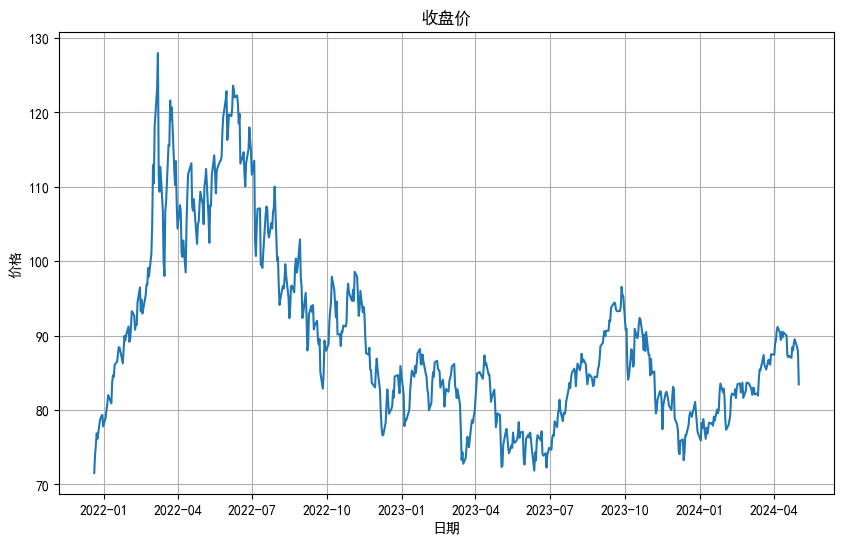

In [37]:
# 绘制收盘价的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(data['日期'], data['收盘'])
plt.title('收盘价')
plt.xlabel('日期')
plt.ylabel('价格')
plt.grid(True) # 加个方格线
plt.show()

In [38]:
# ADF检验函数
def adf_test(timeseries):
    # 进行Dickey-Fuller检验
    result = adfuller(timeseries)
    print('ADF 统计值: %f' % result[0])
    print('p值: %f' % result[1])
    print('临界值:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# 对收盘价进行ADF检验
adf_test(data['收盘'])

ADF 统计值: -1.674490
p值: 0.444302
临界值:
	1%: -3.441
	5%: -2.866
	10%: -2.569


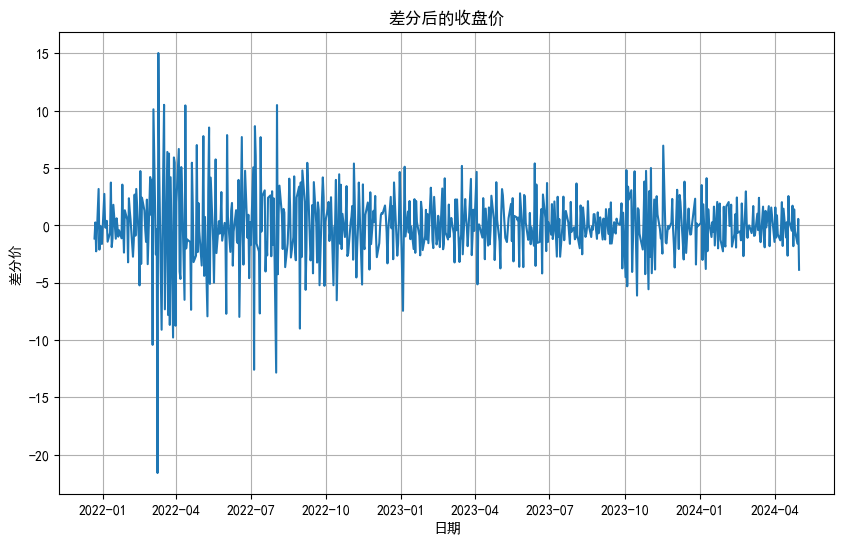

ADF 统计值: -10.573234
p值: 0.000000
临界值:
	1%: -3.442
	5%: -2.866
	10%: -2.569


In [39]:
# 对收盘价进行二阶差分
data_diff = data['收盘'].diff().diff().dropna()

# 绘制差分后的时间序列图
plt.figure(figsize=(10, 6))
plt.plot(data['日期'][2:], data_diff)
plt.title('差分后的收盘价')
plt.xlabel('日期')
plt.ylabel('差分价')
plt.grid(True)
plt.show()

# 对差分后的数据进行ADF检验
adf_test(data_diff)

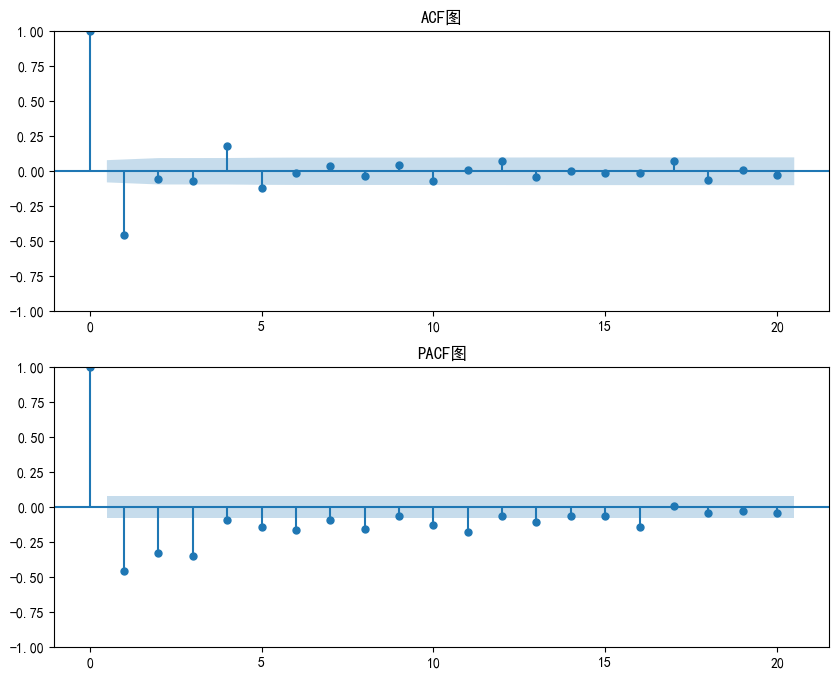

In [41]:
# 绘制ACF和PACF图
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data_diff, lags=20, ax=ax[0], title='ACF图')
plot_pacf(data_diff, lags=20, ax=ax[1], title='PACF图')
plt.show()

#### 可以看出ACF图截尾，PACF图拖尾   ,是MA模型 ，因此要找q值 
####  q为最后一个超出二倍标准差的阶数，也即超出二倍标准差的纵向线数量-1 
####  可以看出q值为2

In [43]:
# 拟合ARIMA模型
model = ARIMA(data['收盘'], order=(0,2,2)) # MA(2) 二阶差分
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     收盘   No. Observations:                  611
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1375.380
Date:                Mon, 20 May 2024   AIC                           2756.761
Time:                        23:58:29   BIC                           2769.996
Sample:                             0   HQIC                          2761.910
                                - 611                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9783      0.131     -7.493      0.000      -1.234      -0.722
ma.L2         -0.0215      0.039     -0.552      0.581      -0.098       0.055
sigma2         5.3056      0.681      7.785      0.000       3.970       6.641
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1609.49
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

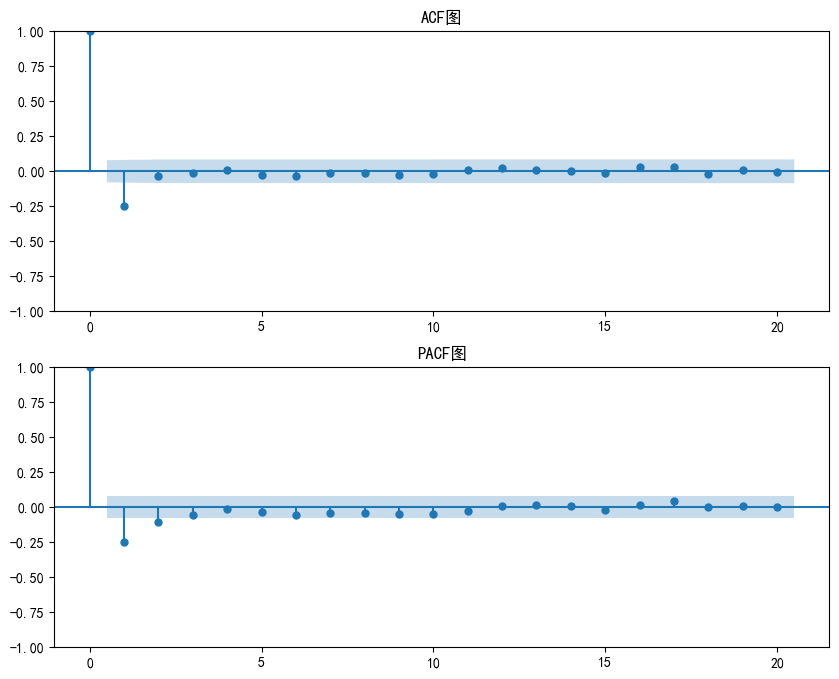

ADF 统计值: -10.191753
p值: 0.000000
临界值:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [44]:
# 残差分析
residuals = model_fit.resid

# 绘制残差的ACF和PACF图
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, lags=20, ax=ax[0], title='ACF图')
plot_pacf(residuals, lags=20, ax=ax[1], title='PACF图')
plt.show()

# 残差的ADF检验
adf_test(residuals)


#### 可以看出，ACF截尾，PACF截尾，不存在明显的自相关性 
#### ADF统计值小于三个value，且p值为0，小于显著性水平则可以拒绝原假设，认为数据不存在单位根，数据是平稳的
#### 综上，可以说该拟合的时间序列模型是有效且可靠的